# SE-ResNet50 on SkyView Dataset (Kaggle, with 80/20 Split, Full Classes)

In [2]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Path to dataset (Kaggle version)
dataset_path = '/kaggle/input/skyview-an-aerial-landscape-dataset/Aerial_Landscapes'

# Load all images from each class, report unreadable images
def load_and_split_by_class(dataset_path, image_size=(224, 224), train_ratio=0.8):
    X_train, y_train, X_test, y_test = [], [], [], []

    for label in sorted(os.listdir(dataset_path)):
        class_dir = os.path.join(dataset_path, label)
        if not os.path.isdir(class_dir):
            continue
        files = sorted(os.listdir(class_dir))
        images = []
        failed = 0
        for file_name in files:
            file_path = os.path.join(class_dir, file_name)
            img = cv2.imread(file_path)
            if img is None:
                failed += 1
                continue
            img = cv2.resize(img, image_size)
            images.append(img)

        print(f"📂 Class '{label}': {len(images)} images loaded, {failed} failed")
        images = shuffle(images, random_state=42)
        split_idx = int(len(images) * train_ratio)
        X_train.extend(images[:split_idx])
        y_train.extend([label] * split_idx)
        X_test.extend(images[split_idx:])
        y_test.extend([label] * (len(images) - split_idx))

    return shuffle(np.array(X_train), np.array(y_train), random_state=42), shuffle(np.array(X_test), np.array(y_test), random_state=42)

(X_train, y_train), (X_test, y_test) = load_and_split_by_class(dataset_path)

le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_test_enc = to_categorical(le.transform(y_test))
class_names = le.classes_.tolist()

print("✅ Each class split 80/20 successfully. Classes:", class_names)


📂 Class 'Agriculture': 800 images loaded, 0 failed
📂 Class 'Airport': 800 images loaded, 0 failed
📂 Class 'Beach': 800 images loaded, 0 failed
📂 Class 'City': 800 images loaded, 0 failed
📂 Class 'Desert': 800 images loaded, 0 failed
📂 Class 'Forest': 800 images loaded, 0 failed
📂 Class 'Grassland': 800 images loaded, 0 failed
📂 Class 'Highway': 800 images loaded, 0 failed
📂 Class 'Lake': 800 images loaded, 0 failed
📂 Class 'Mountain': 800 images loaded, 0 failed
📂 Class 'Parking': 800 images loaded, 0 failed
📂 Class 'Port': 800 images loaded, 0 failed
📂 Class 'Railway': 800 images loaded, 0 failed
📂 Class 'Residential': 800 images loaded, 0 failed
📂 Class 'River': 800 images loaded, 0 failed
✅ Each class split 80/20 successfully. Classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway', 'Residential', 'River']


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15,
                               width_shift_range=0.1, height_shift_range=0.1,
                               horizontal_flip=True)
test_gen = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow(X_train, y_train_enc, batch_size=32)
test_data = test_gen.flow(X_test, y_test_enc, batch_size=32, shuffle=False)


In [4]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam

# SE block definition
def se_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, channels))(se)
    se = Dense(channels // ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    return Multiply()([input_tensor, se])

# Model definition
def build_se_resnet50(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = se_block(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

model = build_se_resnet50((224, 224, 3), y_train_enc.shape[1])

# Fine-tune all layers
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1744632751.887387      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,642,575 (94.00 MB)

 Trainable params: 24,589,455 (93.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [5]:
# Use callbacks to avoid overfitting and improve learning
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
]

history = model.fit(train_data, validation_data=test_data, epochs=20, callbacks=callbacks)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744632812.964621     204 service.cc:148] XLA service 0x7e7504001cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744632812.965646     204 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744632817.479777     204 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/300 ━━━━━━━━━━━━━━━━━━━━ 6:18:24 76s/step - accuracy: 0.0938 - loss: 2.9988

I0000 00:00:1744632838.349659     204 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 171s 317ms/step - accuracy: 0.1716 - loss: 2.5933 - val_accuracy: 0.0667 - val_loss: 11.6073 - learning_rate: 1.0000e-05
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 93s 301ms/step - accuracy: 0.7117 - loss: 1.1203 - val_accuracy: 0.0783 - val_loss: 6.8219 - learning_rate: 1.0000e-05
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 93s 303ms/step - accuracy: 0.8705 - loss: 0.4923 - val_accuracy: 0.5842 - val_loss: 1.4293 - learning_rate: 1.0000e-05
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 93s 301ms/step - accuracy: 0.9170 - loss: 0.2902 - val_accuracy: 0.9608 - val_loss: 0.1406 - learning_rate: 1.0000e-05
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 92s 301ms/step - accuracy: 0.9340 - loss: 0.2321 - val_accuracy: 0.9663 - val_loss: 0.1082 - learning_rate: 1.0000e-05
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 93s 302ms/step - accuracy: 0.9464 - loss: 0.1847 - val_accuracy: 0.9717 - val_loss: 0.1010 - learning_rate: 1.0000e-05
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 91s 297ms/step 

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step
              precision    recall  f1-score   support

 Agriculture       0.97      0.98      0.98       160
     Airport       0.98      0.95      0.97       160
       Beach       0.99      0.99      0.99       160
        City       0.98      0.96      0.97       160
      Desert       0.98      0.98      0.98       160
      Forest       0.99      0.99      0.99       160
   Grassland       0.97      0.97      0.97       160
     Highway       0.99      1.00      0.99       160
        Lake       0.99      0.97      0.98       160
    Mountain       0.97      0.98      0.98       160
     Parking       0.98      0.98      0.98       160
        Port       0.98      0.99      0.98       160
     Railway       0.95      0.96      0.95       160
 Residential       0.99      1.00      0.99       160
       River       0.98      0.97      0.97       160

    accuracy                           0.98      2400
   macro avg       0.98      0.98      0

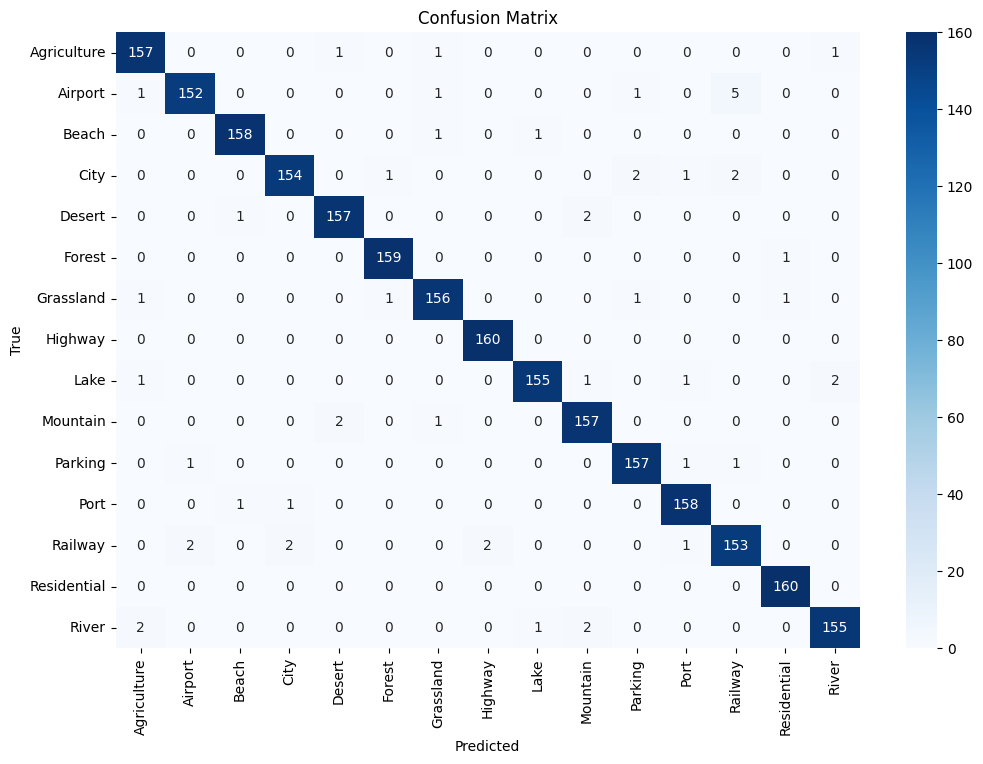

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = np.argmax(model.predict(test_data), axis=1)
y_true = np.argmax(y_test_enc, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
